# 시계열 모멘텀(Time-Series Momentum)

- 참고 문헌 <br>
  Moskowitz, Ooi and Pedersen(2012) : https://www.sciencedirect.com/science/article/pii/S0304405X11002613
  

- 참고 사이트 <br>
 1) https://github.com/rkohli3/TSMOM <br>
 2) https://github.com/anthonyng2/Time-Series-Momentum/blob/master/TSMOM/TS%20MOM.ipynb

In [1]:
# !pip install -U finance-datareader

In [1]:
import pandas as pd
import numpy as np

import matplotlib
import matplotlib.pyplot as plt
from matplotlib import gridspec
import seaborn as sns

import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy.interpolate import UnivariateSpline

import pandas_datareader.data as web
import FinanceDataReader as fdr

from tqdm import tqdm
import warnings; warnings.simplefilter('ignore')

# (목적) Moskowitz, Ooi and Pedersen(2012) Replicate

# 1. Data
- 1984년부터 2009년까지 유동성이 높은 55개의 Futures(commodities(24), currency(9), equity indexes(9), developed government bond(13))
- 출처: https://github.com/quantopian/research_public/tree/master/advanced_sample_analyses/TSMOM/data

In [3]:
# # Data Loading For Colab
# from google.colab import files

# Futures = files.upload()
# Futures_Info = files.upload()

In [4]:
# Data Loading(by pd.read_csv)
Data = pd.read_csv('Futures.csv', parse_dates= True, index_col= [0])
Info = pd.read_csv('Futures_Info.csv')

In [5]:
# Factor Return Loading(by web.DataReader)
ThreeFactors = web.DataReader("F-F_Research_Data_Factors_daily","famafrench", start= Data.index[0])[0]
MomFactors = web.DataReader("F-F_Momentum_Factor_daily","famafrench", start= Data.index[0])[0]
Factors = pd.concat([ThreeFactors, MomFactors], axis = 1)
Factors = Factors.rename(columns = {'Mkt-RF':'MKT', 'Mom   ': 'MOM'})

In [6]:
Factors = Factors.loc[:pd.to_datetime('2009-12-31')]
Factors = Factors/100

Futures = Data.resample('B').first().loc[Factors.index]

In [7]:
# Calculate Excess Return
Futures = Futures.sub(Factors['RF'].shift(1)/365, axis = 0)

## - 1.1 데이터 탐색

In [9]:
Info

,Asset,FUTURES,ASSET_CLASS
0,LA,ALUMINIUM,COMMODITIES
1,CO,BRENT OIL,COMMODITIES
2,LC,CATTLE,COMMODITIES
3,CC,COCOA,COMMODITIES
4,KC,COFFEE,COMMODITIES
5,LP,COPPER,COMMODITIES
6,C,CORN,COMMODITIES
7,CT,COTTON,COMMODITIES
8,CL,CRUDE,COMMODITIES
9,QS,GASOIL,COMMODITIES


In [8]:
Futures.head()

,SM,NO,CL,UB,SB,TP,CD,CN,GC,TY,...,CC,S,SE,NV,HO,GX,JY,FV,JB,LC
Date,,,,,,,,,,,,,,,,,,,,,
1984-01-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1984-01-04,-0.011367,NaN,0.003613,NaN,0.002394,NaN,NaN,NaN,-0.005495,0.004429,...,-0.036875,-0.013713,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.002735
1984-01-05,0.013229,NaN,-0.007319,NaN,-0.011784,NaN,NaN,NaN,-0.005521,-0.000254,...,0.019695,0.017139,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.022080
1984-01-06,-0.029522,NaN,-0.004135,NaN,-0.005357,NaN,NaN,NaN,-0.020647,0.002337,...,-0.043457,-0.031651,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.010452
1984-01-09,-0.022182,NaN,0.009486,NaN,-0.024680,NaN,NaN,NaN,-0.006464,-0.001288,...,-0.034018,-0.015250,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.004294


In [10]:
Factors.head()

,MKT,SMB,HML,RF,MOM
Date,,,,,
1984-01-03,-0.0047,0.0048,0.0009,0.00036,-0.0040
1984-01-04,0.0146,-0.0067,-0.0005,0.00036,-0.0076
1984-01-05,0.0126,-0.0014,-0.0038,0.00036,-0.0001
1984-01-06,0.0042,0.0042,0.0004,0.00036,0.0010
1984-01-09,-0.0022,0.0028,0.0047,0.00036,0.0004


## - 1.2 Summary Statistics Table

In [11]:
# Calculate Statistics Data
FirstDate = Futures.apply(lambda x: x.first_valid_index().strftime('%Y-%m-%d'))
FirstDate.name = 'Start'

# 통계치 연율화
AnnMean = Futures.mean() * 261
AnnStd = Futures.std() * np.sqrt(261)
SharpeRatio = AnnMean/AnnStd

AnnMean.name = 'Ann Mean'
AnnStd.name = 'Ann Volatility'
SharpeRatio.name = 'Sharpe Ratio'

Skewness = Futures.skew()
Skewness.name = 'Skewness'
Kurtosis = Futures.kurt()
Kurtosis.name = 'Kurtosis'

In [12]:
# Create Summary Table1
SumStats = pd.concat([FirstDate, AnnMean, AnnStd, Skewness, Kurtosis, SharpeRatio], axis = 1)
SumStats.index.name = 'Asset'
SumStats.reset_index(inplace= True)

# Asset code 기준으로 Data와 Info Table Merge
SumResult = Info.merge(SumStats)
SumResult.set_index(['asset_class'.upper(), 'futures'.upper()], inplace = True)
del SumResult['Asset']

SumResult.iloc[:, 1:3] = SumResult.iloc[:, 1:3]*100
SumResult.iloc[:, 1:] = SumResult.iloc[:, 1:].applymap(lambda x: np.round(x, 3)) 
SumResult.iloc[:, 1:3] = SumResult.iloc[:, 1:3].applymap(lambda x: str(x)+'%')

Table1 = SumResult
Table1

Start Ann Mean Ann Volatility  \
ASSET_CLASS    FUTURES                                                 
COMMODITIES    ALUMINIUM          1997-07-25  -1.315%        21.783%   
               BRENT OIL          1988-06-27  18.999%        36.259%   
               CATTLE             1984-01-04   0.329%        14.715%   
               COCOA              1984-01-04  -4.007%        30.878%   
               COFFEE             1984-01-04  -2.808%        37.897%   
               COPPER             1997-07-23  12.209%        28.686%   
               CORN               1984-01-04   -9.28%        23.737%   
               COTTON             1984-01-04   -2.96%        25.316%   
               CRUDE              1984-01-04  13.683%        38.244%   
               GASOIL             1989-07-05  15.097%        34.201%   
               GOLD               1984-01-04  -2.865%        16.399%   
               HEAT OIL           1986-07-02  16.773%        37.216%   
               HOGS               1986-04-03  -2.318%         23.75%   
               NAT GAS            1990-04-05  -0.895%        54.049%   
               NICKEL             1997-07-25  18.875%        40.091%   
               PLATINUM           1984-01-30   2.493%        23.635%   
               SILVER             1984-01-04  -2.196%        28.376%   
               SOYBEANS           1984-01-04  -0.745%        23.157%   
               SOYMEAL            1984-01-04   5.634%         24.79%   
               SOYOIL             1984-01-04   -3.28%        24.402%   
               SUGAR              1984-01-04    2.02%        37.497%   
               UNLEADED           2005-10-05   7.235%        44.922%   
               WHEAT              1984-01-04  -6.084%         26.19%   
               ZINC               1997-07-25   1.436%        31.361%   
EQUITY INDEXES AEX (NL)           1989-01-04  -0.165%        25.452%   
               ASX SPI 200 (AUS)  2000-05-04    3.12%        17.151%   
               CAC 40 10 (FR)     1988-12-09   1.945%        23.017%   
               DAX (GER)          1990-11-27   2.523%        24.056%   
               FTSE 100 (UK)      1988-03-01  -0.024%        19.067%   
               FTSE/MIB (IT)      2004-03-24   1.002%        22.911%   
               IBEX 35 (ESP)      1992-07-02   7.166%        24.113%   
               S&P 500 (US)       1997-09-11  -0.872%        22.459%   
               TOPIX (JP)         1990-05-21    -7.1%         24.67%   
BOND           3-year AUS         1989-12-04  -1.909%         1.394%   
               10-year AUS        1987-09-22  -2.529%         1.396%   
               2-year EURO        1997-03-11  -1.432%         1.484%   
               5-year EURO        1991-10-08   0.133%         3.453%   
               10-year EURO       1990-11-27   0.953%         5.396%   
               30-year EURO       1998-10-06   0.311%        10.198%   
               10-year CAN        1989-09-19   0.868%         6.547%   
               10-year JP         1985-10-22   0.634%         5.541%   
               10-year UK         1984-01-04   -1.42%         7.714%   
               2-year US          1990-06-27  -0.866%         1.865%   
               5-year US          1988-05-24   0.107%         4.366%   
               10-year US         1984-01-04   1.652%         7.004%   
               30-year US         1984-01-04   2.941%         10.51%   
CURRENCIES     AUD/USD            1987-01-14   1.625%        12.214%   
               EUR/USD            1998-05-21   0.238%        10.435%   
               CAD/USD            1986-04-07  -0.915%         7.393%   
               JPY/USD            1986-05-28   -3.22%        11.647%   
               NOK/USD            2002-05-20   4.812%          13.7%   
               NZD/USD            1997-05-09   1.936%        14.184%   
               SEK/USD            2002-05-20   3.744%        13.728%   
               CHF/USD            1986-04-08  -1.321%        12.082%   
       

## - 1.3 Ex ante Volatility estimate

 $\sigma^{2}_{t}=261\sum^\infty_{i=0}(1-\delta)\delta^{i}(r_{t-1-i}-\bar{r}_{t})^{2}$ ... (1)
 
 - $t$ = daily time point
 - $r_t$ = daily excess return at time t
 - $\bar{r_t}$ = ewa(지수가중평균) of $r_t$

# 2. Analysis

In [13]:
# Daily Return to Monthly Return
MonReturn = (1 + Futures).resample('M').apply(lambda x: x.prod() if any(x.notnull()) else np.nan) - 1
MonFactors = (1 + Factors).resample('M').prod() - 1

# 식 (1)의 Ex ante 변동성 계산
ExanteVol = Futures.ewm(com = 60).std() * np.sqrt(261)
MonVol = ExanteVol.resample('M').last()
MonVol = MonVol.shift(1)

## - 2.1 Regression Analysis 
: Time Lagged Regression을 통해 시점별 예측력 확인

1) Regression by returns for all assets

$r^{s}_{t}/\sigma^{s}_{t-1}=\alpha+\beta_{h}r^{s}_{t-h}/\sigma^{s}_{t-h-1}+\epsilon^{s}_{t}.$ ... (2)

 - $r^{s}_{t}$ = Monthly excess return of Asset $s$ at time $t$
 - $r^{s}_{t-h}$ = Monthly excess return of Asset $s$ at time $t-h$
 - $\sigma^{s}_{t-1}$ = Annualized Ex ante Volatility of Asset $s$ at time $t-1$
 - $\sigma^{s}_{t-h-1}$ = Annualized Ex ante Volatility of Asset $s$ at time $t-h-1$
 
 *식 5와의 일관성을 위해 수익률보다 한 시점 lagged 된 변동성을 사용

2) Regression by return's sign for all assets and asset classes

$r^{s}_{t}/\sigma^{s}_{t}=\alpha+\beta_{h}sign(r^{s}_{t-h})+\epsilon^{s}_{t}.$ ...(3)

In [14]:
# Fig 1. t-statistic plot of lagged regression 생성하기 위한 함수
def get_lag_tvalue(ReturnData, VolData, nlags = 60, Sign = False):
    '''
    - Params
      1) ReturnData : 식(2), (3)의 회귀분석에 필요한 자산 수익률 데이터
      2) VolData : 식(2), (3)의 회귀분석에 필요한 자산 Ex ante 변동성 데이터(for Scaling)
      3) nlags : 분석하고자 하는 lag의 최대값
      4) Sign : 식 (3)의 설명변수(sign of return) 사용여부
    - Return
      1) t-statistics of Asset(All asset, Asset classes, Individual asset)
    '''
    t_values = pd.Series(index = range(1, nlags, 1))
    for h in tqdm(range(1, nlags, 1)):
        # t, t-h 시점의 Scaled Return 생성
        Scale_t = ReturnData/VolData
        Scale_t_h = Scale_t.shift(h)
        # if Sign == True: 식 (3) else: 식 (2)
        if Sign == True:
            Scale_t_h[Scale_t_h>0] = 1
            Scale_t_h[Scale_t_h<0] = -1
        else:
            pass
        # Pooled Regression을 위해 Scale된 Return Data Stacking
        X0 = Scale_t_h.stack()
        y = Scale_t.stack()
        new_index = set(y.dropna().index).intersection(X0.index)

        # Pooled Regression 수행
        y= y[new_index]
        X0 = X0[new_index]
        X = sm.add_constant(X0)
        t_value = sm.OLS(y, X).fit().tvalues[0]
        t_values[h] = t_value
    
    return t_values

In [15]:
# Fig 1 A, Fig 1 B. t-statistic by month, all asset classes t-statistic 산출
AllTvalue = get_lag_tvalue(MonReturn, MonVol, nlags = 60, Sign = False)
AllSignTvalue = get_lag_tvalue(MonReturn, MonVol, nlags = 60, Sign = True)

AllTvalue.name = 'all asset classes(return)'
AllSignTvalue.name = 'all asset classes'

100%|██████████████████████████████████████████████████████████████████████████████████| 59/59 [01:02<00:00,  1.06s/it]


In [16]:
# Fig 1 C t-statistic by month, asset classe 별 t-statistic 산출

# Asset Class 별 자산 code list 생성
AssetClass_ls = [Info[Info['ASSET_CLASS'] == asset]['Asset'] for asset in Info['ASSET_CLASS'].unique()]

# Asset Class 별 t-statistic 값 산출
AssetTvalue = pd.DataFrame(columns = Info['ASSET_CLASS'].unique())
for AssetName, Asset in zip(AssetTvalue.columns, AssetClass_ls):    
    AssetTvalue.loc[:, AssetName] = get_lag_tvalue(MonReturn[Asset], MonVol[Asset], nlags = 60, Sign = True)

100%|██████████████████████████████████████████████████████████████████████████████████| 59/59 [00:12<00:00,  4.78it/s]


In [17]:
# Fig 1. 을 그리기 위해 생성된 각 t-statistic DataFrame  하나의 DataFrame으로 합치기
t_value_result = pd.concat([AllTvalue, AllSignTvalue, AssetTvalue], axis = 1)

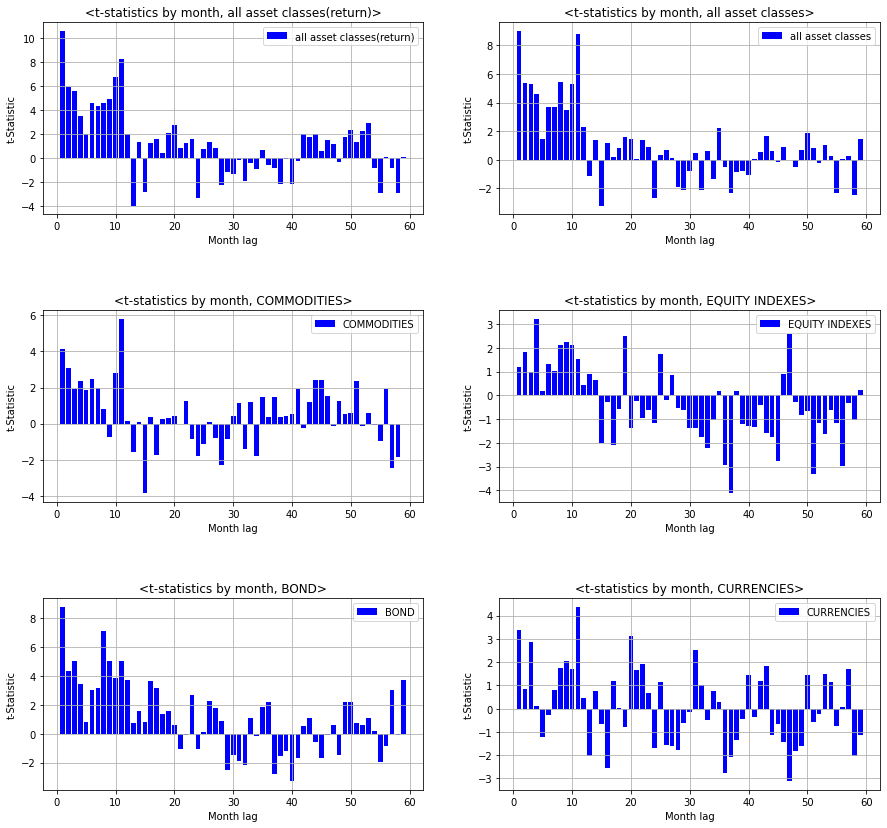

In [18]:
# Fig 1. 그리기
fig = plt.figure(figsize = (15, 30))
gs = gridspec.GridSpec(nrows = 6,
                       ncols = 2)
for i in range(len(t_value_result.columns)):
    ax = plt.subplot(gs[i])
    ax.bar(t_value_result.index, t_value_result.iloc[:, i], label = t_value_result.iloc[:, i].name, color = 'blue')
    ax.set_xlabel('Month lag')
    ax.set_ylabel('t-Statistic')
    ax.set_title(f'<t-statistics by month, {t_value_result.iloc[:, i].name}>')
    ax.grid(True)
    ax.legend()
plt.subplots_adjust(hspace=0.5, wspace=0.2)
plt.show()

## - 2.2 Time series momentum trading strategies
: Lookback기간과 보유기간에 따른 Time Series Momentum 전략의 성과(by 4 Factor Regression)를 통해 Lookback 기간과 보유기간 결정

In [19]:
# Table2. Lookback기간과 보유기간에 따른 Time Series Momentum 전략의 성과(by 4 Factor Regression) 표 생성을 위한 함수
def get_alphas(ReturnData, VolData, FactorData, Lookback, Holding):
    '''
    - Params
      1) ReturnData : Time Series Momentum 전략 수행에 필요한 자산 수익률 데이터
      2) VolData : 수익률의 Scaling을 위해 필요한 자산 Ex ante 변동성 데이터
      3) FactorData : Factor Regression 수행을 위해 필요한 Factor 수익률 데이터(4 Factor)
      4) Lookback : Lookback 기간
      5) Holding : 보유기간
    - Returns
      1) PortfolioReturn : 각 전략(Lookback기간, 보유기간의 변경) 수행 시 포트폴리오 수익률
      2) r_value : 각 전략 별 포트폴리오 수익률의 평균
      3) a_value : 각 전략 별 포트폴리오 수익률의 Alpha(by 4 Factor Regression)
      4) t_value : 각 전략 별 포트폴리오 수익률의 Alpha(by 4 Factor Regression)의 T-value
    '''
    Lookback = Lookback
    Holding = Holding
    # 보유기간 고려한 날짜 데이터
    PortIndex = ReturnData.resample(str(Holding)+'M').last().index
    
    # Lookback 기간별 Holding Period Return을 통해 Signal Data 생성
    LBReturn = (1.+ReturnData).rolling(window= Lookback + 1).agg(lambda x : x.prod()) - 1
    LBReturn[LBReturn > 0] = 1
    LBReturn[LBReturn < 0] = -1

    # Portfolio 수익률 생성
    PortfolioReturn = pd.Series(index = ReturnData.index)
    for start_date, end_date in zip(PortIndex[:-1], PortIndex[1:]):
        # 보유기간 날짜 데이터
        port_period = (start_date < ReturnData.index) & (ReturnData.index <= end_date)
        # 리밸런싱 시점의 Signal 정보
        Signal = LBReturn.loc[start_date].dropna()
        # 포트폴리오 수익률 계산
        PortReturn = Signal*(0.4/VolData.loc[port_period])*ReturnData.loc[port_period]
        PortfolioReturn.loc[port_period] = PortReturn.mean(axis = 1)
    # 4 Factor Regression 수행
    RegData = pd.concat([FactorData.iloc[Lookback+1:, :], PortfolioReturn.iloc[Lookback+1:]], axis = 1)
    RegData = RegData.rename(columns = {0:'Port'})
    
    model = smf.ols(formula = 'Port ~ MKT + SMB + HML + MOM', data = RegData)
    result = model.fit()
    r_value = PortfolioReturn.mean()
    a_value = result.params[0]
    t_value = result.tvalues[0]
    
    return PortfolioReturn, r_value, a_value, t_value

- Table 2 생성

In [20]:
month_ls = [1, 3, 6, 9, 12, 24, 36, 48]
index = [['Lookback period(months)', 'Lookback period(months)', 'Lookback period(months)', 'Lookback period(months)', 'Lookback period(months)', 'Lookback period(months)', 'Lookback period(months)', 'Lookback period(months)'],
           month_ls]
columns =[['Holding period(months)', 'Holding period(months)', 'Holding period(months)', 'Holding period(months)', 'Holding period(months)', 'Holding period(months)', 'Holding period(months)', 'Holding period(months)'],
           month_ls]

In [21]:
Table2A_R = pd.DataFrame(index= month_ls, columns = month_ls)
Table2A_T = pd.DataFrame(index= month_ls, columns = month_ls)
for L in tqdm(month_ls):
    for H in month_ls:
        _, Table2A_R.loc[L, H], _, Table2A_T.loc[L, H] = get_alphas(MonReturn, MonVol, MonFactors, L, H)
Table2A_R.index = index; Table2A_R.columns = columns
Table2A_T.index = index; Table2A_T.columns = columns

100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [05:00<00:00, 37.53s/it]


In [22]:
print(f'All Asset Classes: 월평균 수익률(%)')
Table2A_R*100

All Asset Classes: 월평균 수익률(%)


Holding period(months)                      \
                                               1         3         6    
Lookback period(months) 1                1.185593  0.542919  0.491539   
                        3                1.111311  0.681719  0.544774   
                        6                1.060668  0.852664  0.882442   
                        9                1.302351  1.206951  0.935767   
                        12               1.144628  0.964722  0.584632   
                        24               0.577457  0.485121  0.446189   
                        36               0.369447  0.316765  0.148776   
                        48               0.316378  0.224148  0.138937   

                                                                              
                                  9         12        24        36        48  
Lookback period(months) 1   0.585749  0.463740  0.358730  0.192188  0.268593  
                        3   0.790851  0.744237  0.440114  0.399957  0.558781  
                        6   0.910864  0.554369  0.423572  0.270006  0.571149  
                        9   0.823562  0.487872  0.321914  0.401645  0.433802  
                        12  0.529600  0.230142  0.131443  0.010311  0.368949  
                        24  0.369205  0.164768  0.098158  0.167172  0.186684  
                        36  0.289039 -0.062378  0.315172  0.176989  0.195681  
                        48  0.269463 -0.060503  0.283676  0.149929  0.261317

In [23]:
print(f'All Asset Classes: t-value of alpha(by 4F Regression)')
Table2A_T

All Asset Classes: t-value of alpha(by 4F Regression)


Holding period(months)                      \
                                               1         3         6    
Lookback period(months) 1                5.728163  2.397874  1.761506   
                        3                5.257379  3.005221  1.727746   
                        6                4.877182  3.672436  3.805757   
                        9                6.104537  5.579821  3.910819   
                        12               5.374474  4.267691  2.423665   
                        24               2.520371  1.836036  1.552596   
                        36               1.617214  1.215495  0.288922   
                        48               1.192189  0.689909  0.229709   

                                                                              
                                  9         12        24        36        48  
Lookback period(months) 1   2.773467  1.771297  1.110816  0.734101  0.534162  
                        3   3.638669  3.344806  1.711684  2.127187  2.031918  
                        6   4.092274  2.326939  1.694162  1.223036  2.008914  
                        9   3.594737  1.770150  1.272547  1.456085  1.778328  
                        12  2.451196  0.690468  0.097207 -0.209403  1.188153  
                        24  1.380996  0.237762  0.415810  0.668164  1.001904  
                        36  1.215623 -0.670148  1.169739  0.749626  0.667743  
                        48  0.957977 -0.887789  0.992385  0.439035  0.868226

In [24]:
AssetName = [asset for asset in Info['ASSET_CLASS'].unique()]

In [25]:
AssetReturnDict = [MonReturn.loc[:, Info[Info['ASSET_CLASS'] == asset]['Asset']] for asset in Info['ASSET_CLASS'].unique()]
AssetVolDict = [MonVol.loc[:, Info[Info['ASSET_CLASS'] == asset]['Asset']] for asset in Info['ASSET_CLASS'].unique()]

In [26]:
Table2B_R = pd.DataFrame(index= month_ls, columns = month_ls)
Table2B_T = pd.DataFrame(index= month_ls, columns = month_ls)
for L in tqdm(month_ls):
    for H in month_ls:
        _, Table2B_R.loc[L, H], _, Table2B_T.loc[L, H] = get_alphas(AssetReturnDict[0], AssetVolDict[0], MonFactors, L, H)
Table2B_R.index = index
Table2B_R.columns = columns
Table2B_T.index = index
Table2B_T.columns = columns

100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [02:29<00:00, 18.69s/it]


In [27]:
print(f'{AssetName[0]}: 월평균 수익률(%)')
Table2B_R*100

COMMODITIES: 월평균 수익률(%)


Holding period(months)                      \
                                               1         3         6    
Lookback period(months) 1                0.977473  0.452962  0.427766   
                        3                0.947459  0.590632  0.361266   
                        6                0.920925  0.754670  0.669047   
                        9                1.188609  1.034939  0.777224   
                        12               0.961946  0.794358  0.370804   
                        24               0.443264  0.320377  0.214925   
                        36               0.234433  0.082435 -0.027714   
                        48               0.385330  0.342997  0.205773   

                                                                              
                                  9         12        24        36        48  
Lookback period(months) 1   0.394158  0.325863  0.347969  0.026436  0.484368  
                        3   0.729378  0.526816  0.263087  0.089301  0.494582  
                        6   0.868258  0.365338 -0.089774 -0.069122  0.445358  
                        9   0.659992  0.261832  0.167344 -0.038411  0.512427  
                        12  0.239124  0.049621 -0.026143 -0.146167  0.462624  
                        24  0.137701  0.091214  0.210519  0.180744  0.514244  
                        36 -0.063864 -0.190707  0.349137  0.404193  0.134955  
                        48  0.254679 -0.037856  0.313673  0.204869  0.347605

In [28]:
print(f'{AssetName[0]}: t-value of alpha(by 4F Regression)')
Table2B_T

COMMODITIES: t-value of alpha(by 4F Regression)


Holding period(months)                      \
                                               1         3         6    
Lookback period(months) 1                4.124731  1.836946  1.632241   
                        3                3.923778  2.319733  1.152071   
                        6                3.756244  2.732164  2.198247   
                        9                4.740700  4.048142  2.914757   
                        12               4.024684  3.119950  1.233990   
                        24               1.480974  0.912407  0.509696   
                        36               0.773346  0.088757 -0.467066   
                        48               1.139733  1.023757  0.497150   

                                                                              
                                  9         12        24        36        48  
Lookback period(months) 1   1.511382  0.555247  1.000978 -0.085647  1.310377  
                        3   3.196340  2.049537  1.219386  0.428921  1.900414  
                        6   3.648762  1.144599 -0.388614 -0.270902  1.701561  
                        9   2.585464  0.632566  0.627165 -0.369348  1.950676  
                        12  0.969028 -0.159355 -0.204984 -0.715855  1.720314  
                        24  0.231130 -0.059375  0.626441  0.492634  1.650079  
                        36 -0.451707 -1.251671  0.987429  1.135962 -0.027984  
                        48  0.660076 -0.680800  0.716431  0.234026  0.704137

In [29]:
Table2C_R = pd.DataFrame(index= month_ls, columns = month_ls)
Table2C_T = pd.DataFrame(index= month_ls, columns = month_ls)
for L in tqdm(month_ls):
    for H in month_ls:
        _, Table2C_R.loc[L, H], _, Table2C_T.loc[L, H] = get_alphas(AssetReturnDict[1], AssetVolDict[1], MonFactors, L, H)
Table2C_R.index = index
Table2C_R.columns = columns
Table2C_T.index = index
Table2C_T.columns = columns

100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [01:10<00:00,  8.79s/it]


In [30]:
print(f'{AssetName[1]}: 월평균 수익률(%)')
Table2C_R*100

EQUITY INDEXES: 월평균 수익률(%)


Holding period(months)                      \
                                               1         3         6    
Lookback period(months) 1                0.419358  0.531080  0.913236   
                        3                1.151235  0.671368  1.011065   
                        6                1.055726  1.049050  1.323649   
                        9                0.881604  1.137918  0.997246   
                        12               0.982370  0.899948  0.457523   
                        24               0.508573  0.634039  0.782777   
                        36               0.537361  0.594216  0.114515   
                        48              -0.116408 -0.444278 -0.696719   

                                                                              
                                  9         12        24        36        48  
Lookback period(months) 1   0.826746  0.163947  0.730518  0.703104  0.969955  
                        3   0.374367  0.513886  0.601955  0.696141  0.818355  
                        6   0.894840  0.226968  0.887776  0.638267  1.027758  
                        9   0.516312  0.316497  0.463278  0.606365  0.644339  
                        12  0.490854  0.002414  0.589585  0.229970  0.693499  
                        24  0.390254  0.104792 -0.779635  0.069978 -0.747833  
                        36  0.299422 -0.687198 -0.462651 -0.247955 -0.465764  
                        48 -0.370098 -0.792004 -0.229665 -0.472298 -0.794763

In [31]:
print(f'{AssetName[1]}: t-value of alpha(by 4F Regression)')
Table2C_T

EQUITY INDEXES: t-value of alpha(by 4F Regression)


Holding period(months)                      \
                                               1         3         6    
Lookback period(months) 1                0.637025  0.679894  1.322752   
                        3                1.552341  0.884103  0.777030   
                        6                1.330825  0.981443  1.851711   
                        9                0.845464  1.361674  1.115186   
                        12               1.270922  1.077576  0.410362   
                        24               0.850052  1.164652  1.248543   
                        36               1.041183  1.128151  0.238287   
                        48              -0.169675 -0.847005 -1.399607   

                                                                              
                                  9         12        24        36        48  
Lookback period(months) 1   1.050477 -0.102450  0.721778  1.313674  1.193141  
                        3  -0.075889  0.142237  0.710057  1.122766  1.132137  
                        6   0.765080 -0.003952  1.246849  1.375625  1.409985  
                        9   0.515162  0.354269  0.708715  1.377498  1.000422  
                        12  0.229358 -0.447331  0.371487  0.467616  0.743569  
                        24  0.627040 -0.001811 -1.225299  0.406915 -0.252891  
                        36  0.345309 -1.588530 -1.197744 -0.297261 -0.654047  
                        48 -0.626168 -1.689240 -0.598029 -0.440284 -1.571263

In [32]:
Table2D_R = pd.DataFrame(index= month_ls, columns = month_ls)
Table2D_T = pd.DataFrame(index= month_ls, columns = month_ls)
for L in tqdm(month_ls):
    for H in month_ls:
        _, Table2D_R.loc[L, H], _, Table2D_T.loc[L, H] = get_alphas(AssetReturnDict[2], AssetVolDict[2], MonFactors, L, H)
Table2D_R.index = index
Table2D_R.columns = columns
Table2D_T.index = index
Table2D_T.columns = columns

100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [01:31<00:00, 11.39s/it]


In [33]:
print(f'{AssetName[2]}: 월평균 수익률(%)')
Table2D_R*100

BOND: 월평균 수익률(%)


Holding period(months)                      \
                                               1         3         6    
Lookback period(months) 1                1.945834  1.072462  0.585361   
                        3                1.649387  0.829837  0.744479   
                        6                1.333635  1.320080  1.287361   
                        9                1.589321  1.531047  1.324026   
                        12               1.699002  1.357982  1.094991   
                        24               1.053569  0.876745  1.072603   
                        36               0.598273  0.800129  0.514392   
                        48               0.462688  0.458495  0.548341   

                                                                              
                                  9         12        24        36        48  
Lookback period(months) 1   0.912764  0.831379  0.240854  0.230481 -0.694854  
                        3   1.525080  1.328629  0.765567  0.586529  0.780427  
                        6   1.454460  1.246033  1.493815  0.792567  0.869164  
                        9   1.343327  1.082514  0.884075  0.971792  0.396521  
                        12  1.385858  0.916972  0.587442  0.115510  0.139693  
                        24  1.088054  0.629231  0.483372  0.480598  0.077255  
                        36  0.725473  0.335512  0.525901  0.139934  0.527370  
                        48  0.529588  0.257211  0.442860  0.232643  0.476858

In [34]:
print(f'{AssetName[2]}: t-value of alpha(by 4F Regression)')
Table2D_T

BOND: t-value of alpha(by 4F Regression)


Holding period(months)                      \
                                               1         3         6    
Lookback period(months) 1                3.937870  2.099978  0.617913   
                        3                3.509381  1.696060  0.935967   
                        6                2.516667  2.921000  2.812184   
                        9                3.311208  3.540063  2.440322   
                        12               3.303033  2.558022  1.912099   
                        24               2.409378  1.867318  2.395355   
                        36               1.583607  1.983431  1.440679   
                        48               1.000505  0.960940  1.302057   

                                                                              
                                  9         12        24        36        48  
Lookback period(months) 1   1.880677  1.814169  0.223818  0.452896 -1.796640  
                        3   3.174100  3.176655  1.192499  1.552556  0.957543  
                        6   3.171919  3.160187  3.161570  2.103493  1.072517  
                        9   2.724346  2.136527  1.913941  2.054460  0.895940  
                        12  2.887591  2.103138  0.935604  0.216091  0.001796  
                        24  2.435883  1.477405  1.454394  1.369929  0.415532  
                        36  1.844655  1.014108  1.309224  0.631650  1.341397  
                        48  1.213832  0.641413  1.367326  0.423183  1.455031

In [35]:
Table2E_R = pd.DataFrame(index= month_ls, columns = month_ls)
Table2E_T = pd.DataFrame(index= month_ls, columns = month_ls)
for L in tqdm(month_ls):
    for H in month_ls:
        _, Table2E_R.loc[L, H], _, Table2E_T.loc[L, H] = get_alphas(AssetReturnDict[3], AssetVolDict[3], MonFactors, L, H)
Table2E_R.index = index
Table2E_R.columns = columns
Table2E_T.index = index
Table2E_T.columns = columns

100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [01:07<00:00,  8.45s/it]


In [36]:
print(f'{AssetName[3]}: 월평균 수익률(%)')
Table2E_R*100

CURRENCIES: 월평균 수익률(%)


Holding period(months)                      \
                                               1         3         6    
Lookback period(months) 1                1.084866  0.357793  0.234444   
                        3                0.896079  0.490551  0.352362   
                        6                0.877382  0.021234  0.440534   
                        9                1.192841  1.121822  0.809506   
                        12               0.999920  1.066843  0.695206   
                        24               0.333726  0.320019  0.105475   
                        36               0.323006  0.295260  0.247119   
                        48              -0.013439 -0.153470 -0.265252   

                                                                              
                                  9         12        24        36        48  
Lookback period(months) 1   0.350727  0.651510  0.434352  0.041620  0.528681  
                        3   0.276570  0.700319  0.536936  0.417426  0.428980  
                        6   0.398352  0.149819  0.054559 -0.187263  0.264030  
                        9   0.720631  0.633961  0.237400  0.597419  0.330276  
                        12  0.510620  0.243472 -0.267428 -0.104503  0.180243  
                        24  0.174560 -0.118712 -0.298080 -0.303695 -0.075590  
                        36  0.756158  0.244314  0.373703 -0.354423  0.265283  
                        48  0.233287 -0.144933  0.189090  0.118029 -0.076648

In [37]:
print(f'{AssetName[3]}: t-value of alpha(by 4F Regression)')
Table2E_T

CURRENCIES: t-value of alpha(by 4F Regression)


Holding period(months)                      \
                                               1         3         6    
Lookback period(months) 1                2.618543  1.121921  0.603639   
                        3                2.318126  1.186638  0.777693   
                        6                2.173971  0.026945  0.881905   
                        9                2.835338  2.549480  1.689808   
                        12               2.500246  2.788173  1.563236   
                        24               0.711062  0.484051 -0.288052   
                        36               0.628572  0.419959 -0.034946   
                        48              -0.094280 -0.458736 -0.862251   

                                                                              
                                  9         12        24        36        48  
Lookback period(months) 1   1.150630  1.964753  0.932305  0.232396  1.384681  
                        3   1.002953  1.696255  1.035246  1.156784  0.830122  
                        6   0.802173 -0.197442 -0.163688 -0.910640  0.303755  
                        9   1.654022  1.193437  0.381460  1.215490  0.504477  
                        12  1.131768  0.108180 -0.792934 -0.194785  0.237062  
                        24  0.321708 -0.688662 -0.783249 -0.568176 -0.326254  
                        36  1.539018  0.590320  1.022715 -0.426248  0.587654  
                        48  0.609398 -0.509232  0.222405  0.336673 -0.424313

## - 2.3 Time series momentum(Lookback = 12, Holding = 1) portfolio의 성과

$r^{TSMOM,s}_{t,t+1} = sign(r^{s}_{t-12,t})($40%$/\sigma^{s}_{t})r^{s}_{t,t+1}.$ ... (5)

 - $r^{TSMOM,s}_{t,t+1}$ = TSMOM return of Asset $s$ at time $t$
 - $r^{s}_{t-12,t}$ = Holding period return of Asset $s$ from time $t-12$ to time $t$

$r^{TSMOM}_{t,t+1} = (1/S_t)\sum^{S_t}_{s=1}sign(r^{s}_{t-12,t})($40%$/\sigma^{s}_{t})r^{s}_{t,t+1}.$

 - $S_t$ = number of Securities at time $t$

In [38]:
# Time Series Momentum(Lookback = 12, Holding = 1) Portfolio Return을 생성하는 함수
# Long Only, Short Only, Long Short 세 가지 포지션의 Portfolio Return 생성 가능
def get_portfolio_return(ReturnData, VolData, Lookback = 12, Holding = 1, LongP = False, ShortP = False):
    '''
    - Params
      1) ReturnData : Time Series Momentum 전략 수행에 필요한 자산 수익률 데이터
      2) VolData : 수익률의 Scaling을 위해 필요한 자산 Ex ante 변동성 데이터
      3) Lookback : Lookback 기간
      4) Holding : 보유기간
      5) LongP : Long Position 여부
      6) ShortP : Short Position 여부
    - Return
      1) PortfolioReturn : Time Series Momentum(Lookback = 12, Holding = 1) 포트폴리오 수익률
    '''
    Lookback = Lookback
    Holding = Holding
    PortIndex = ReturnData.resample(str(Holding)+'M').last().index

    LBReturn = (1.+ReturnData).rolling(window= Lookback + 1).agg(lambda x : x.prod()) - 1
    SignLS = LBReturn.copy()
    SignLS[SignLS > 0] = 1
    SignLS[SignLS < 0] = -1

    SignL = LBReturn.copy()
    SignL[SignL > 0] = 1
    SignL[SignL < 0] = 0

    SignS = LBReturn.copy()
    SignS[SignL < 0] = 1
    SignS[SignL > 0] = 0

    PortPolioReturn = pd.DataFrame(index = ReturnData.index, columns = ReturnData.columns)
    for start_date, end_date in zip(PortIndex[:-1], PortIndex[1:]):
        port_period = (start_date < ReturnData.index) & (ReturnData.index <= end_date)
        if (LongP == True)&(ShortP == False):
            Signal = SignL.loc[port_period]
            PortPolioReturn.loc[port_period] = Signal*(0.4/VolData.loc[port_period])*ReturnData.loc[port_period]
        elif(LongP == False)&(ShortP == True):
            Signal = SignS.loc[port_period]
            PortPolioReturn.loc[port_period] = Signal*(0.4/VolData.loc[port_period])*ReturnData.loc[port_period]
        elif(LongP == True)&(ShortP == True):
            Signal = SignLS.loc[port_period]
            PortPolioReturn.loc[port_period] = Signal*(0.4/VolData.loc[port_period])*ReturnData.loc[port_period]
            
    return PortPolioReturn

In [39]:
TSMOMReturn = get_portfolio_return(MonReturn, MonVol, Lookback = 12, Holding = 1, LongP = True, ShortP = True)
LonlyPortReturn = get_portfolio_return(MonReturn, MonVol, Lookback = 12, Holding = 1, LongP = True, ShortP = False)
SonlyPortReturn = get_portfolio_return(MonReturn, MonVol, Lookback = 12, Holding = 1, LongP = False, ShortP = True)

- Sharpe Ratio를 통한 자산 별 Time Series Momentum 포트폴리오 성과 비교

In [40]:
MonRF = (1+Factors['RF']).resample('M').prod() - 1
ExcessTSMOMReturn = TSMOMReturn.sub(MonRF.shift(1), axis = 0)

In [41]:
SPRatio = (ExcessTSMOMReturn.shift(1).mean()*12)/(TSMOMReturn.std()*np.sqrt(12))
SPRatio = pd.DataFrame(SPRatio, columns = ['SPRatio'])
SPRatio_info = Info.merge(SPRatio.reset_index().rename(columns ={'index':'Asset'}))
del SPRatio_info['Asset']

In [42]:
SPRatio_info = SPRatio_info.replace('BOND', 'FIXED INCOME')
SPRatio_info = SPRatio_info.sort_values(by = ['ASSET_CLASS', 'FUTURES'], ascending = True)

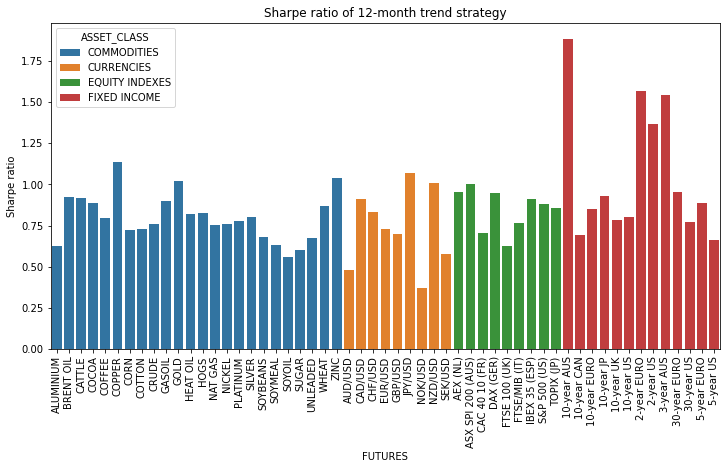

In [43]:
# Fig 2. Asset Class 별 TS Momentum 수익률의 Sharpe Ratio 그래프 생성
plt.figure(figsize = (12, 6))
sns.barplot(x='FUTURES', y='SPRatio', data=SPRatio_info, hue='ASSET_CLASS', dodge=False)
plt.title('Sharpe ratio of 12-month trend strategy')
plt.xticks(rotation=90)
plt.ylabel('Sharpe ratio')
plt.show()

In [44]:
TS_Mom = TSMOMReturn.mean(axis = 1).dropna()
LongTsMom = LonlyPortReturn.mean(axis = 1).dropna()
ShortTsMom = SonlyPortReturn.mean(axis = 1).dropna()

In [45]:
print(f'Time Series Momentum 연평균 수익률: {round(TS_Mom.mean()*12*100, 3)}%')

Time Series Momentum 연평균 수익률: 38.839%


- Time Series Momentum 포트폴리오 수익률 분석 by Factor Regression

In [46]:
RegData = pd.concat([MonFactors, TS_Mom], axis = 1)
RegData = RegData.rename(columns = {0:'Port'})
RegData = RegData.dropna()

In [47]:
model = smf.ols(formula = 'Port ~ MKT + SMB + HML + MOM', data = RegData) # smf.ols는 Intercept term 자동으로 추가
results = model.fit()

In [48]:
# Table3의 Panel A : Monthly Return 기준
Table3A_1 = pd.DataFrame(index = ['Coef', 't-Stat'], columns = ['MKT', 'SMB','HML', 'UMD', 'Intercept(%)', 'R2'])
Table3A_1.loc['Coef'] = [results.params[1], results.params[2], results.params[3], results.params[4], results.params[0], results.rsquared]
Table3A_1.loc['t-Stat'] = [results.tvalues[1], results.tvalues[2], results.tvalues[3], results.tvalues[4], results.tvalues[0], np.nan]
Table3A_1.index.name = 'Monthly'

In [49]:
Table3A_1.loc['Coef', 'Intercept(%)'] = Table3A_1.loc['Coef', 'Intercept(%)']*100

In [50]:
Table3A_1.astype(float).round(2)

,MKT,SMB,HML,UMD,Intercept(%),R2
Monthly,,,,,,
Coef,-0.09,-0.07,-0.08,0.21,3.17,0.12
t-Stat,-1.86,-1.04,-1.09,4.97,15.57,NaN


In [51]:
QRegData = (1+RegData).resample('q').prod() - 1
model = smf.ols(formula = 'Port ~ MKT + SMB + HML + MOM', data = QRegData) # smf.ols는 Intercept term 자동으로 추가
results = model.fit()

In [52]:
# Table3의 Panel A : Quarterly Return 기준
Table3A_2 = pd.DataFrame(index = ['Coef', 't-Stat'], columns = ['MKT', 'SMB','HML', 'UMD', 'Intercept(%)', 'R2'])
Table3A_2.loc['Coef'] = [results.params[1], results.params[2], results.params[3], results.params[4], results.params[0], results.rsquared]
Table3A_2.loc['t-Stat'] = [results.tvalues[1], results.tvalues[2], results.tvalues[3], results.tvalues[4], results.tvalues[0], np.nan]
Table3A_2.index.name = 'Quarterly'

In [53]:
Table3A_2.loc['Coef', 'Intercept(%)'] = Table3A_2.loc['Coef', 'Intercept(%)']*100

In [54]:
Table3A_2.astype(float).round(2)

,MKT,SMB,HML,UMD,Intercept(%),R2
Quarterly,,,,,,
Coef,-0.12,-0.19,-0.07,0.23,9.85,0.17
t-Stat,-1.28,-1.26,-0.59,2.70,13.11,NaN


In [55]:
QRegData['MKT2'] = QRegData['MKT']**2
model = smf.ols(formula = 'Port ~ 0 + MKT+ MKT2', data = QRegData) # smf.ols는 Intercept term 자동으로 추가
results = model.fit()

In [56]:
# Table3의 Panel C : Quarterly Return 기준 
Table3C = pd.DataFrame(index = ['Coef', 't-Stat'], columns = ['MKT', 'MKT squared'])
Table3C.loc['Coef'] = [results.params[0], results.params[1]]
Table3C.loc['t-Stat'] = [results.tvalues[0], results.tvalues[1]]
Table3C.index.name = 'Quarterly'

In [57]:
Table3C.astype(float).round(4)

,MKT,MKT squared
Quarterly,,
Coef,-0.0141,4.8710
t-Stat,-0.1193,6.5005


- Time Series Momentum 포트폴리오 수익률 비교 \
1) Time Series Momentum in Paper Data : Long Only, Short Only, Long Short, S&P500 \
2) Time Series Momentum in S&P500 : Long Only, Short Only, Long Short, S&P500

In [58]:
SnP500 = fdr.DataReader(symbol='US500', start=TS_Mom.index[0], end=TS_Mom.index[-1])
SnP500Return = SnP500['Adj Close'].pct_change()
SnP500Return = SnP500Return.sub(Factors.reindex(SnP500Return.index)['RF'].shift(1)/365, axis = 0)

In [59]:
SnPMonReturn = (1+SnP500Return).resample('M').prod() - 1
TS_Mom = TS_Mom.reindex(SnPMonReturn.index)

In [60]:
SnPVol = SnP500Return.ewm(com = 60).std() * np.sqrt(261)
SnPMonVol = SnPVol.resample('M').last()
SnPMonVol = SnPMonVol.shift(1)

In [61]:
LongTsMom.iloc[0] = 0
ShortTsMom.iloc[0] = 0
SnPMonReturn.iloc[0] = 0
TS_Mom.iloc[0] = 0

LongTsMom_cum = (1+LongTsMom).cumprod()*100
ShortTsMom_cum = (1+ShortTsMom).cumprod()*100
SnPMonReturn_cum = (1+SnPMonReturn).cumprod()*100
TS_Mom_cum = (1+TS_Mom).cumprod()*100

In [62]:
MAXp_LongTsMom = LongTsMom_cum.cummax()
DDp_LongTsMom = (LongTsMom_cum/MAXp_LongTsMom - 1)*100  # 단위: %

MAXp_ShortTsMom = ShortTsMom_cum.cummax()
DDp_ShortTsMom = (ShortTsMom_cum/MAXp_ShortTsMom - 1)*100  # 단위: %

MAXp_SnP = SnPMonReturn_cum.cummax()
DDp_SnP = (SnPMonReturn_cum/MAXp_SnP - 1)*100  # 단위: %

MAXp_TS = TS_Mom_cum.cummax()
DDp_TS = (TS_Mom_cum/MAXp_TS - 1) * 100  # 단위: %

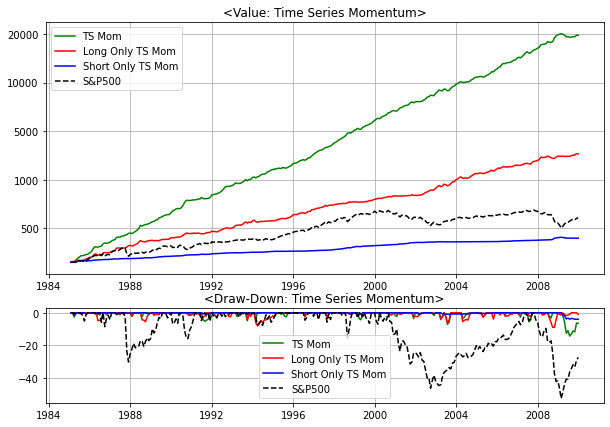

In [63]:
# Fig 3. 누적 수익률 그래프
fig = plt.figure(figsize = (10, 7))    # figsize = (가로길이, 세로길이)
gs = gridspec.GridSpec(nrows = 2,      # row 개수
                       ncols = 1,      # col 개수
                       height_ratios=[8, 3], # subplot의 크기를 서로 다르게 설정
                       width_ratios=[5])

ax0 = plt.subplot(gs[0])

ax0.plot(np.log(TS_Mom_cum), label = 'TS Mom', c = 'g')
ax0.plot(np.log(LongTsMom_cum), label = 'Long Only TS Mom', c = 'r')
ax0.plot(np.log(ShortTsMom_cum), label = 'Short Only TS Mom', c = 'b')
ax0.plot(np.log(SnPMonReturn_cum), label = 'S&P500', c = 'black', linestyle = '--')
ax0.set_yticklabels([100, 500, 1000, 5000, 10000, 20000]) # 로그스케일 이지만 표시는 raw scale로 표시(논문과 동일)
ax0.set_title('<Value: Time Series Momentum>')
ax0.grid(True)
ax0.legend()

ax1 = plt.subplot(gs[1])
ax1.plot(DDp_TS, label = 'TS Mom', c = 'g')
ax1.plot(DDp_LongTsMom, label = 'Long Only TS Mom', c = 'r')
ax1.plot(DDp_ShortTsMom, label = 'Short Only TS Mom', c = 'b')
ax1.plot(DDp_SnP, label = 'S&P500', c = 'black', linestyle = '--')
ax1.set_title('<Draw-Down: Time Series Momentum>')
ax1.grid(True)
ax1.legend()

plt.show()

- Time Series Momentum of S&P500

In [64]:
LBReturn = (1.+SnPMonReturn).rolling(window= 12 + 1).agg(lambda x : x.prod()) - 1
LBReturn = LBReturn.dropna()

SnPMonR = SnPMonReturn.reindex(LBReturn.index)
SnPMonV = SnPMonVol.reindex(LBReturn.index)

SignLS = LBReturn.copy()
SignLS[SignLS > 0] = 1
SignLS[SignLS < 0] = -1

SignL = LBReturn.copy()
SignL[SignL > 0] = 1
SignL[SignL < 0] = 0

SignS = LBReturn.copy()
SignS[SignL < 0] = 1
SignS[SignL > 0] = 0

L_SnPPort = SignL*(0.4/SnPMonV)*SnPMonR
S_SnPPort = SignS*(0.4/SnPMonV)*SnPMonR
LS_SnPPort = SignLS*(0.4/SnPMonV)*SnPMonR

In [65]:
L_SnPPort.iloc[0] = 0
S_SnPPort.iloc[0] = 0
LS_SnPPort.iloc[0] = 0
SnPPort = SnPMonReturn.reindex(L_SnPPort.index)
SnPPort.iloc[0] = 0

L_SnPPort_cum = (1+L_SnPPort).cumprod()*100
S_SnPPort_cum = (1+S_SnPPort).cumprod()*100
LS_SnPPort_cum = (1+LS_SnPPort).cumprod()*100
SnPPort_cum = (1+SnPPort).cumprod()*100

In [66]:
MAXp_L_SnPPort = L_SnPPort_cum.cummax()
DDp_L_SnPPort = (L_SnPPort_cum/MAXp_L_SnPPort - 1)*100  # 단위: %

MAXp_S_SnPPort = S_SnPPort_cum.cummax()
DDp_S_SnPPort = (S_SnPPort_cum/MAXp_S_SnPPort - 1)*100  # 단위: %

MAXp_LS_SnPPort = LS_SnPPort_cum.cummax()
DDp_LS_SnPPort = (LS_SnPPort_cum/MAXp_LS_SnPPort - 1)*100  # 단위: %

MAXp_SnPPort = SnPPort_cum.cummax()
DDp_SnPPort = (SnPPort_cum/MAXp_SnPPort - 1)*100  # 단위: %

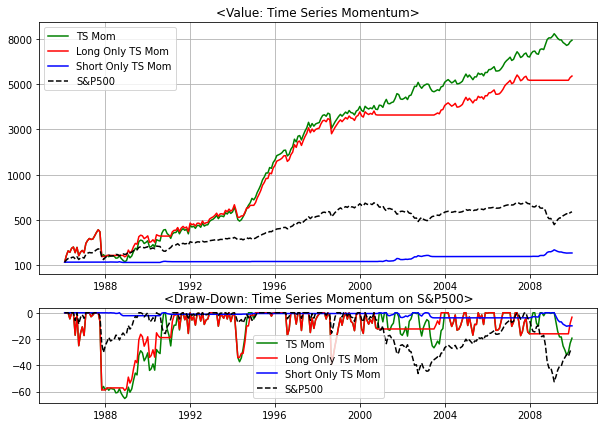

In [67]:
# Fig 3. 추가 분석: S&P500을 사용한  누적 수익률 그래프
fig = plt.figure(figsize = (10, 7))    # figsize = (가로길이, 세로길이)
gs = gridspec.GridSpec(nrows = 2,      # row 개수
                       ncols = 1,      # col 개수
                       height_ratios=[8, 3], # subplot의 크기를 서로 다르게 설정
                       width_ratios=[5])

ax0 = plt.subplot(gs[0])

ax0.plot(np.log(LS_SnPPort_cum), label = 'TS Mom', c = 'g')
ax0.plot(np.log(L_SnPPort_cum), label = 'Long Only TS Mom', c = 'r')
ax0.plot(np.log(S_SnPPort_cum), label = 'Short Only TS Mom', c = 'b')
ax0.plot(np.log(SnPPort_cum), label = 'S&P500', c = 'black', linestyle = '--')
ax0.yaxis.set_major_locator(matplotlib.ticker.MaxNLocator(6))
ax0.set_yticklabels([0, 100, 500, 1000, 3000, 5000, 8000]) # 로그스케일 이지만 표시는 raw scale로 표시(논문과 동일)
ax0.set_title('<Value: Time Series Momentum>')
ax0.grid(True)
ax0.legend()

ax1 = plt.subplot(gs[1])
ax1.plot(DDp_LS_SnPPort, label = 'TS Mom', c = 'g')
ax1.plot(DDp_L_SnPPort, label = 'Long Only TS Mom', c = 'r')
ax1.plot(DDp_S_SnPPort, label = 'Short Only TS Mom', c = 'b')
ax1.plot(DDp_SnPPort, label = 'S&P500', c = 'black', linestyle = '--')
ax1.set_title('<Draw-Down: Time Series Momentum on S&P500>')
ax1.grid(True)
ax1.legend()

plt.show()

- Time Series Momentum 포트폴리오 수익률과 S&P500 수익률 산점도 \
: Quarterly Return을 사용하여 비교

In [68]:
x = SnPMonReturn.fillna(0)
y = TS_Mom

x = (1+x).resample('q').prod() - 1
y = (1+TS_Mom).resample('q').prod() -1

Text(0, 0.5, 'TSMOM Returns %')

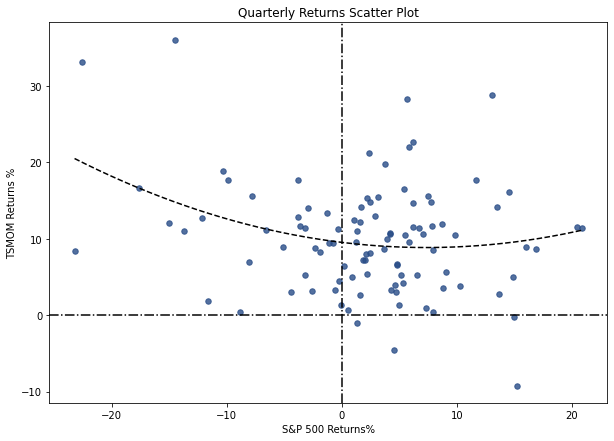

In [69]:
# Fig 4. 산점도 그래프
ax, fig = plt.subplots(figsize = (10, 7))
plt.scatter(x * 100, y * 100,c = '#284c87',marker= 'o', s = 30,alpha = 0.8)
model = np.polyfit(x = x * 100,y = y * 100,deg = 2)
f = np.poly1d(model)
xs = np.linspace(np.min(x) * 100,np.max(x) * 100,250)
ys = f(xs)
plt.plot(xs, ys, ls = '--', c = 'black')
plt.axhline(y = 0, c = 'k', ls = '-.')
plt.axvline(x = 0, c = 'k', ls = '-.')
plt.title('Quarterly Returns Scatter Plot')
plt.xlabel('S&P 500 Returns%')
plt.ylabel('TSMOM Returns %')